In [11]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import numpy as np
import itertools  
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


In [12]:
from keras import layers
from keras.models import Model, Sequential

from functools import partial

conv3 = partial(layers.Conv2D,
                kernel_size=3,
                strides=1,
                padding='same',
                activation='relu')

def block(in_tensor, filters, n_convs):
    conv_block = in_tensor
    for _ in range(n_convs):
        conv_block = conv3(filters=filters)(conv_block)
    return conv_block

def _vgg(in_shape=(50,50,3),
         n_classes=3,
         opt='sgd',
         n_stages_per_blocks=[2, 2, 3, 3, 3]):
    in_layer = layers.Input(in_shape)

    block1 = block(in_layer, 64, n_stages_per_blocks[0])
    pool1 = layers.MaxPool2D()(block1)
    block2 = block(pool1, 128, n_stages_per_blocks[1])
    pool2 = layers.MaxPool2D()(block2)
    block3 = block(pool2, 256, n_stages_per_blocks[2])
    pool3 = layers.MaxPool2D()(block3)
    block4 = block(pool3, 512, n_stages_per_blocks[3])
    pool4 = layers.MaxPool2D()(block4)
    block5 = block(pool4, 512, n_stages_per_blocks[4])
    pool5 = layers.MaxPool2D()(block5)
    flattened = layers.GlobalAvgPool2D()(pool5)

    dense1 = layers.Dense(1096, activation='relu')(flattened)
    dense2 = layers.Dense(512, activation='relu')(dense1)
    preds = layers.Dense(3, activation='softmax')(dense2)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model

def vgg16(in_shape=(50,50,3), n_classes=3, opt='sgd'):
    return _vgg(in_shape, n_classes, opt)

def vgg19(in_shape=(50,50,3), n_classes=3, opt='sgd'):
    return _vgg(in_shape, n_classes, opt, [2, 2, 4, 4, 4])

if __name__ == '__main__':
    model = vgg19()
    print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 64)        1792      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0         
__________

In [13]:
from keras import optimizers
model.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 33

training_set = train_datagen.flow_from_directory('rice3/train/',
                                                 target_size=(50,50),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory('rice3/valid/',
                                            target_size=(50,50),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 450 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [15]:
class_dict = training_set.class_indices
print(class_dict)
li = list(class_dict.keys())
print(li)

{'BrownSpot': 0, 'Healthy': 1, 'Leaf Blight': 2}
['BrownSpot', 'Healthy', 'Leaf Blight']


In [5]:
history = model.fit_generator(training_set,
                         steps_per_epoch=450/33,
                         validation_data=valid_set,
                         epochs=40,
                         verbose=1,
                         validation_steps=300/33)
#saving model
filepath="vggnetModel.hdf5"
model.save(filepath)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
14/13 [==============================] - 72s 5s/step - loss: 1.0986 - acc: 0.3170 - val_loss: 1.0985 - val_acc: 0.3333
Epoch 2/40
14/13 [==============================] - 66s 5s/step - loss: 1.0985 - acc: 0.3226 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 3/40
14/13 [==============================] - 64s 5s/step - loss: 1.0984 - acc: 0.3333 - val_loss: 1.0983 - val_acc: 0.3333
Epoch 4/40
14/13 [==============================] - 64s 5s/step - loss: 1.0983 - acc: 0.3322 - val_loss: 1.0982 - val_acc: 0.3333
Epoch 5/40
14/13 [==============================] - 57s 4s/step - loss: 1.0983 - acc: 0.3182 - val_loss: 1.0981 - val_acc: 0.3333
Epoch 6/40
14/13 [==============================] - 53s 4s/step - loss: 1.0983 - acc: 0.3549 - val_loss: 1.0981 - val_acc: 0.3333
Epoch 7/40
14/13 [==============================] - 52s 4s/step - loss: 1.0982 - acc: 0.3845 - val_loss: 1.0980 - val_acc: 0.4567
Epoch 8/40
14/13 [========================

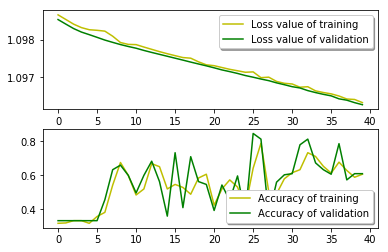

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='y', label="Loss value of training")
ax[0].plot(history.history['val_loss'], color='g', label="Loss value of validation",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='y', label="Accuracy of training")
ax[1].plot(history.history['val_acc'], color='g',label="Accuracy of validation")
legend = ax[1].legend(loc='best', shadow=True) 

In [19]:

Y_pred = model.predict_generator(valid_set,300/33)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_set.classes, y_pred))
print('Classification Report')
target_names = ['BrownSpot','Healthy','Leaf Blight']
print(classification_report(valid_set.classes, y_pred, target_names=target_names))


Confusion Matrix
[[  0   0 100]
 [  0   0 100]
 [  0   0 100]]
Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.00      0.00      0.00       100
     Healthy       0.00      0.00      0.00       100
 Leaf Blight       0.33      1.00      0.50       100

   micro avg       0.33      0.33      0.33       300
   macro avg       0.11      0.33      0.17       300
weighted avg       0.11      0.33      0.17       300



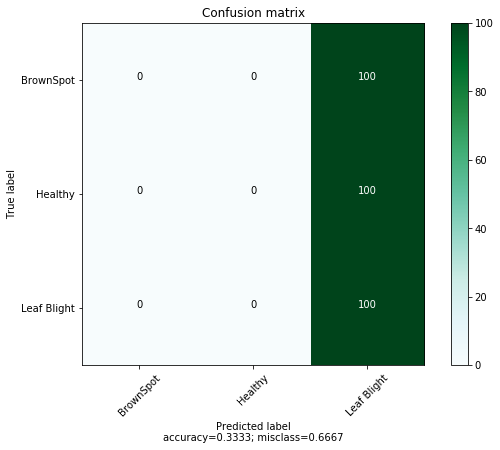

In [20]:



def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
  
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(confusion_matrix(valid_set.classes, y_pred), target_names = ['BrownSpot','Healthy','Leaf Blight'],cmap='BuGn') 
